In [4]:
from TSP_QUBO_Methods import *
import numpy as np

methods = [
    "Nelder-Mead",  # Algoritmo simplex (no requiere derivadas)
    "Powell",       # Algoritmo de búsqueda direccional (sin derivadas)
    "L-BFGS-B",     # Variante limitada de BFGS (acepta restricciones de caja)
    "TNC",          # Algoritmo de Newton truncado (adecuado para problemas grandes)
    "COBYLA",       # Optimización secuencial por aproximaciones cuadráticas
    "SLSQP"         # Programación cuadrática secuencial
]

distances = np.loadtxt("./data/matriz-rutas-granada")

# Global Parameters

N = 5
p_list = [3,1,1]
startNodes = [0,1,2]
endNodes = [3,5,3]

iterations_single = 300
iterations_multi = 200
bidireccionality_single = False
bidireccionality_multi = False
method = methods[2]


# Process Parameters (for single line the first element is used)

for index, p in enumerate(p_list):
    p_list[index] = min(N-1, p)
    startNodes[index] = min(N-1, startNodes[index])
    endNodes[index] = min(N-1, endNodes[index])

p = p_list[0]
startNode = startNodes[0]
endNode = endNodes[0]

L = len(p_list)

reduced_distances = distances[:N,:N]/np.max(distances[:N,:N])
distances_QUBO = convertCostMatrixToQUBORepresentation(reduced_distances, p)

Solution: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0]
Distance of the solution: 1.0735205702997508




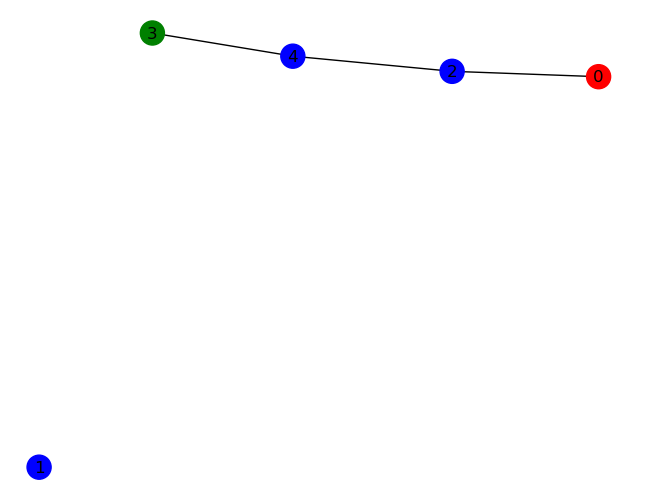

In [2]:
# Brute force solution. Uninformed lambdas

manual_lambdas = [1.0, 2.0, 13.0, 8.0, 10.0]
constraints_activations = [True, True, True, True, True]

Q_matrix, _ = createQUBOmatrix(reduced_distances, p, startNode, endNode, manual_lambdas, constraints_activations)

solutions_zipped = brute_force_finding(Q_matrix, reduced_distances, p)

solution = np.array(list(solutions_zipped[0][0]), dtype=int)
distance_of_solution = solutions_zipped[0][-1]

print("Solution:", solution)
print("Distance of the solution:", distance_of_solution)
print("\n")

check_solution(solution, N, p, startNode, endNode)

draw_solution_graph(solution, reduced_distances, p, startNode, endNode)


Cost of naive solution: 1.6953343449091969
Total cost of naive solution: 3.314361514309981


The solution is incorrect
Constraint 1 not fulfilled. Some stops are activated at the same time.
Constraint 3 not fulfilled. Some stops are visited more than once.


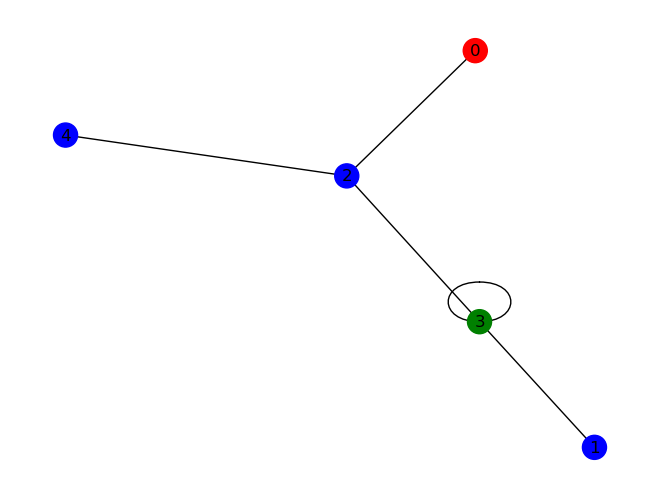

In [5]:
# Single line solution. Informed lambdas. Dwave annealing

naive_solution = generate_valid_initial_solution(N, p, startNode, endNode)
cost_naive_solution = calculate_cost(naive_solution, distances_QUBO)
total_cost_naive_solution = calculate_distances_cost_of_bidireccional_routes(naive_solution, distances_QUBO, N, p)
check_solution(naive_solution, N, p, startNode, endNode)

print("Cost of naive solution:", cost_naive_solution)
print("Total cost of naive solution:", total_cost_naive_solution)
print("\n")

# Compute the solution using the optimized lambdas and the Dwave simulator
# Compute the solution using the optimized lambdas and the Dwave simulator and assuming bidirecctional routes

resultsDict = contruct_complete_solution(reduced_distances, p, startNode, endNode, method, iterations_single, bidireccionality_single)

lambdas = resultsDict["lambdas"]
best_solution = resultsDict["best_solution"]
best_solution_cost = resultsDict["best_solution_cost"]
best_solution_total_cost = resultsDict["best_solution_total_cost"]
Q_matrix = resultsDict["Q_matrix"]

if resultsDict["solution_validity"]:
    print("The solution is correct")
    print("Cost of the solution:", best_solution_cost)
    print("Total cost of the solution:", best_solution_total_cost)
    print("\n")
    draw_solution_graph(best_solution, reduced_distances, p, startNode, endNode)

    if is_symmetric(Q_matrix, tol=1):
        print("\n Q_matrix is symmetric")
        np.savetxt("./data/Q_matrix_TSP", Q_matrix)

else:
    print("The solution is incorrect")
    check_solution(best_solution, N, p, startNode, endNode)
    draw_solution_graph(best_solution, reduced_distances, p, startNode, endNode)


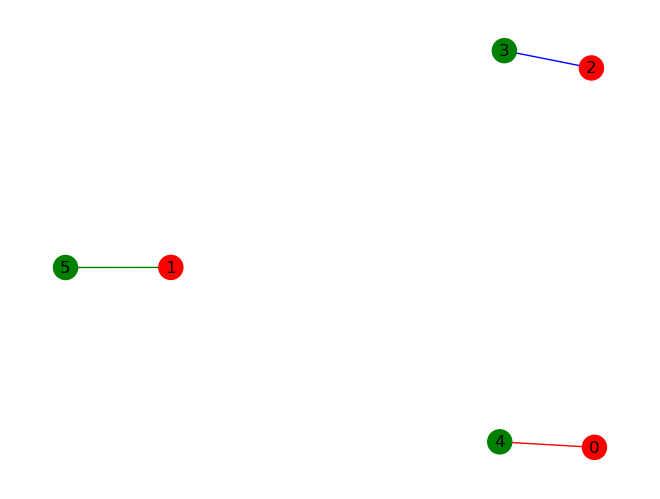

In [14]:
# Multi lines analysis

resultsDict = compute_multiple_lines_solution(reduced_distances, p_list, startNodes, endNodes, method, iterations_multi, bidireccionality_multi)

joint_solution_array = joint_solution(resultsDict, p_list, N)

joint_solution_cost = joint_distance_cost(resultsDict)

draw_multiple_solutions(joint_solution_array, reduced_distances, p_list, startNodes, endNodes)

Solution: [1 0 0 0 0 0 0 0 0 0 1 0]
Cost of the solution: 0.39501083149627336
Total cost of the solution: 0.8613091318579594
Validity of the solution: True


Solution: [0 1 0 0 0 0 0 0 0 0 0 1]
Cost of the solution: 0.3181596953820608
Total cost of the solution: 0.6399648811398362
Validity of the solution: True


Solution: [0 0 1 0 0 0 0 0 0 1 0 0]
Cost of the solution: 0.4600856976533349
Total cost of the solution: 1.0145819615028582
Validity of the solution: True




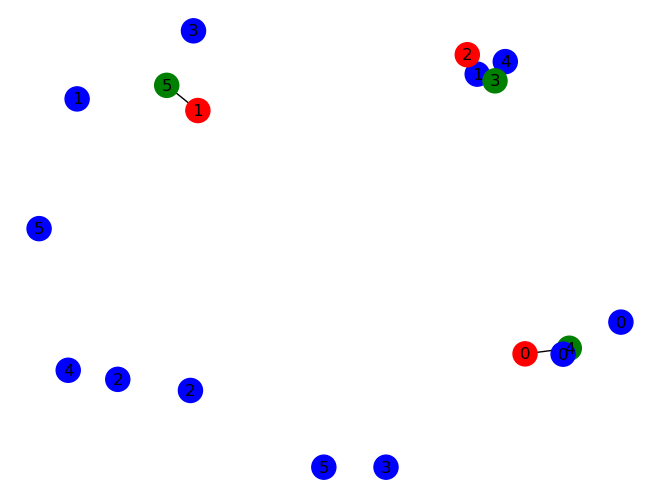

In [15]:
for index, solution in enumerate(resultsDict["best_solutions"]):
    print("Solution:", solution)
    print("Cost of the solution:", resultsDict["best_costs"][index])
    print("Total cost of the solution:", resultsDict["best_total_costs"][index])
    print("Validity of the solution:", resultsDict["solutions_validity"][index])
    print("\n")
    draw_solution_graph(solution, reduced_distances, p_list[index], startNodes[index], endNodes[index])

Validity of the solution: False
Completeness of the solution: False
Cost of the solution: 2.512935764932673


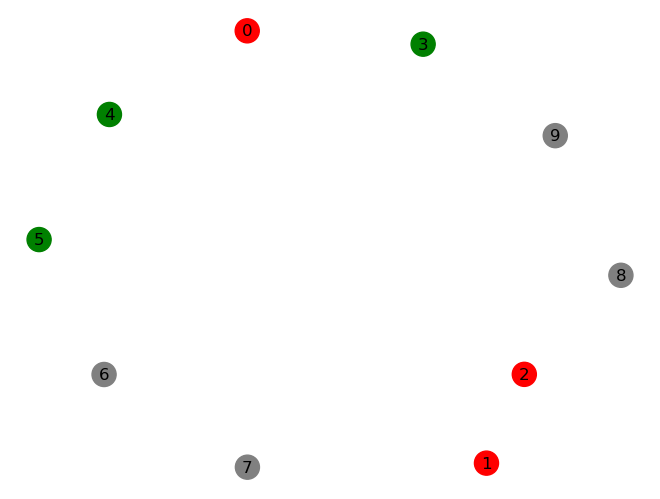

In [5]:
# Find a complete solution iteratively

total_iterations = 1000
longitude = 5

resultsDict, p_list, validity_flag, completeness_flag = create_valid_complete_graph(reduced_distances, N, L, startNodes, endNodes, longitude, total_iterations)

joint_solution_array = joint_solution(resultsDict, p_list, N)

joint_solution_cost = joint_distance_cost(resultsDict)

print("Validity of the solution:", validity_flag)
print("Completeness of the solution:", completeness_flag)
print("Cost of the solution:", joint_solution_cost)

draw_multiple_solutions(joint_solution_array, reduced_distances, p_list, startNodes, endNodes)
